![Course header](../assets/img/header.png)

# 02 — Data Analysis Basics: Your EO Toolbox

**Runtime ≈ 2–3 hours** · pandas + NumPy + Matplotlib

In notebook 01 you learned core Python with standard-library tools.
Now we add the **three libraries** you will use every single day in EO analysis:

| Library | What it does |
|---------|--------------|
| **pandas** | Tables — load, filter, group, export |
| **NumPy** | Arrays — fast math on grids of numbers |
| **Matplotlib** | Plots — histograms, scatter, images |

---

## How this notebook works

Each section follows this pattern:

1. **Question** — a realistic EO question.
2. **Tool** — the pandas / NumPy / Matplotlib feature that answers it.
3. **Result** — run the code and see the answer.

Look for:
- **✅ Try it** exercises
- **🧠 Checkpoints** (combine concepts)
- **⚠️ Common mistakes** (avoid these)
- **💡 Tips**

## Table of contents

1. Setup & data loading
2. pandas essentials — load, select, `loc`/`iloc`, filter, sort, group, `.apply()`, export, merge, method chaining
3. Datetime (tactical)
4. NumPy essentials — arrays, shapes, dtypes, masking, raster thinking
5. Matplotlib essentials — line plot, histogram, scatter, twin axes, imshow
6. 🧠 Mini capstone — build a processing shortlist
7. Wrap-up

---

## 1) Setup & data loading

We load two small datasets that represent a real EO workflow:

| File | What | Shape |
|------|------|---------|
| `eo_scene_catalog.csv` | Scene metadata — 24 rows, 4 tiles, 2 platforms | table |
| `eo_ndvi_stack.npz` | NDVI values + cloud masks — 24 scenes × 32×32 px | array |

### What is NDVI?

**NDVI** (Normalised Difference Vegetation Index) measures how green vegetation is.
It ranges from **–1 to 1**: values above ~0.3 usually indicate healthy vegetation,
while values near 0 suggest bare soil, water, or cloud-contaminated pixels.

You will compute NDVI yourself in Notebook 05 — here we use pre-computed values
so you can focus on the analysis tools.

### What is a cloud mask?

A **cloud mask** is a boolean array (`True` / `False`) that marks which pixels are
obscured by clouds. We use it to exclude unreliable pixels before computing statistics.

### The `.npz` format

`.npz` is NumPy's built-in archive format — it bundles multiple arrays into a single
compressed file. You open it with `np.load()` and access arrays by name, like a dictionary.

### How the two files relate

Row *i* in the CSV catalog describes the **same scene** as slice `[i]` in the NumPy
arrays. This 1-to-1 alignment is what lets us combine tabular metadata (cloud cover,
tile, date) with raster pixel values (NDVI, cloud mask).

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path('..') / 'data'
OUT_DIR  = Path('..') / 'outputs'
OUT_DIR.mkdir(exist_ok=True)

print('pandas:', pd.__version__)
print('numpy: ', np.__version__)

pandas: 3.0.0
numpy:  2.4.2


In [2]:
df = pd.read_csv(DATA_DIR / 'eo_scene_catalog.csv')
print(f'Loaded {len(df)} rows, {len(df.columns)} columns')
df.head()

Loaded 24 rows, 5 columns


,scene_id,tile,platform,datetime,cloud_cover
0,S2A_T32UQD_2024-03-15_cloud15,T32UQD,S2A,2024-03-15T10:30:00Z,15.2
1,S2B_T32UQD_2024-04-15_cloud22,T32UQD,S2B,2024-04-15T10:30:00Z,22.2
2,S2B_T32UQD_2024-05-15_cloud28,T32UQD,S2B,2024-05-15T10:30:00Z,28.7
3,S2A_T32UQD_2024-06-15_cloud55,T32UQD,S2A,2024-06-15T10:30:00Z,55.0
4,S2A_T32UQD_2024-07-15_cloud19,T32UQD,S2A,2024-07-15T10:30:00Z,19.5


In [3]:
npz = np.load(DATA_DIR / 'eo_ndvi_stack.npz', allow_pickle=True)
ndvi       = npz['ndvi']
cloud_mask = npz['cloud']
scene_ids  = npz['scene_id']
datetimes  = npz['datetime']

print('ndvi shape:      ', ndvi.shape, ndvi.dtype)
print('cloud_mask shape:', cloud_mask.shape, cloud_mask.dtype)
print('scene_ids:       ', scene_ids[:3], '...')

ndvi shape:       (24, 32, 32) float32
cloud_mask shape: (24, 32, 32) bool
scene_ids:        ['S2A_T32UQD_2024-03-15_cloud15' 'S2B_T32UQD_2024-04-15_cloud22'
 'S2B_T32UQD_2024-05-15_cloud28'] ...


---

## 2) pandas essentials

pandas deals with two main data structures:

| Structure | Dimensions | Think of it as |
|-----------|------------|----------------|
| **Series** | 1-D | A single column (a labelled array) |
| **DataFrame** | 2-D | A table of aligned columns |

When you call `pd.read_csv()`, pandas reads the file and returns a **DataFrame**.
Each column of that DataFrame is a **Series**. You'll see both terms throughout
this notebook — the distinction matters because some operations only work on one type.

> 💡 **Good habit:** Before writing any analysis code, always inspect your data.
> Check its size (`shape`), column types (`dtypes`), and summary statistics (`describe`).
> This catches problems like missing values, wrong types, or unexpected ranges early.

**Question:** What columns does this catalog have?  What are their types?

### 2.1) First look — shape, dtypes, describe

In [4]:
print('Shape:', df.shape)
print()
df.dtypes

Shape: (24, 5)



scene_id           str
tile               str
platform           str
datetime           str
cloud_cover    float64
dtype: object

In [5]:
df.describe()

,cloud_cover
count,24.000000
mean,25.945833
std,12.747480
min,6.400000
25%,14.875000
50%,26.150000
75%,34.975000
max,55.000000


In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   scene_id     24 non-null     str    
 1   tile         24 non-null     str    
 2   platform     24 non-null     str    
 3   datetime     24 non-null     str    
 4   cloud_cover  24 non-null     float64
dtypes: float64(1), str(4)
memory usage: 1.1 KB


### Key summary functions

| Method | What it tells you |
|--------|-------------------|
| `df.shape` | (rows, columns) |
| `df.dtypes` | data type per column |
| `df.describe()` | count, mean, std, min, max for numbers |
| `df.info()` | types + missing values |
| `df.head(n)` / `df.tail(n)` | first / last n rows |
| `df['col'].value_counts()` | frequency table |

In [7]:
# How many scenes per tile?
df['tile'].value_counts()

tile
T32UQD    6
T32UPD    6
T33UUP    6
T33UVP    6
Name: count, dtype: int64

In [8]:
# How many scenes per platform?
df['platform'].value_counts()

platform
S2A    14
S2B    10
Name: count, dtype: int64

### 2.2) Selecting columns

**Question:** What are the scene IDs and their cloud cover?

When you select a **single column** with `df['col']`, pandas returns a **Series** — a one-dimensional labelled array. When you select **multiple columns** with
`df[['col1', 'col2']]`, you get back a **DataFrame** (a table).

In [9]:
# One column → Series
df['cloud_cover'].head()

0    15.2
1    22.2
2    28.7
3    55.0
4    19.5
Name: cloud_cover, dtype: float64

In [10]:
# Multiple columns → DataFrame
df[['scene_id', 'cloud_cover']].head()

,scene_id,cloud_cover
0,S2A_T32UQD_2024-03-15_cloud15,15.2
1,S2B_T32UQD_2024-04-15_cloud22,22.2
2,S2B_T32UQD_2024-05-15_cloud28,28.7
3,S2A_T32UQD_2024-06-15_cloud55,55.0
4,S2A_T32UQD_2024-07-15_cloud19,19.5


### ⚠️ Common mistake — single vs. double brackets

- `df['cloud_cover']` → a **Series** (single column).
- `df[['cloud_cover']]` → a **DataFrame** (table with 1 column).
- `df['cloud_cover', 'tile']` → **KeyError!** (missing the inner `[]`).

### 2.2b) Selecting with `loc` and `iloc`

pandas offers two precise selectors beyond `[]`:

| Selector | Selects by | End-point included? |
|----------|-----------|---------------------|
| `df.loc[rows, cols]` | **labels** (index values, column names) | ✅ yes |
| `df.iloc[rows, cols]` | **integer positions** (0-based) | ❌ no |

> ⚠️ **Key difference:** `loc` *includes* both endpoints, while `iloc` *excludes* the
> stop — just like Python slicing.

In [ ]:
# loc — select by label (row index + column name)
df.loc[0:3, ['scene_id', 'cloud_cover']]   # rows 0, 1, 2, 3 (inclusive!)

In [ ]:
# iloc — select by integer position
df.iloc[0:3, 0:2]   # rows 0, 1, 2 (stop excluded!) — first two columns

#### ✅ Try it — `loc` vs `iloc`

Use `loc` to select rows 5–10 and columns `scene_id`, `tile`, `cloud_cover`.
Then use `iloc` to get the same result with integer positions.

<details>
<summary>Show solution</summary>

```python
# with loc (labels — endpoints included)
df.loc[5:10, ['scene_id', 'tile', 'cloud_cover']]

# with iloc (positions — stop excluded, need column indices)
df.iloc[5:11, [0, 2, 3]]
```

</details>

In [ ]:
# ✅ loc vs iloc — your code here


### 2.3) Filtering rows — boolean indexing

**Question:** Which scenes have cloud cover below 20%?

In [ ]:
mask = df['cloud_cover'] < 20
print(f'{mask.sum()} scenes with cloud < 20%')
df[mask]

#### Multiple conditions

In pandas, use `&` (and), `|` (or), `~` (not).  
**Wrap each condition in parentheses.**

In [ ]:
# Low cloud AND tile T32UQD
good = df[(df['cloud_cover'] < 25) & (df['tile'] == 'T32UQD')]
print(f'{len(good)} good scenes for T32UQD')
good

### ⚠️ Common mistake — `and` vs `&`

In pandas you must use `&` / `|` / `~`, **not** `and` / `or` / `not`.  
And don't forget the parentheses: `(df['a'] > 5) & (df['b'] < 10)`.

### ✅ Try it — filter

Filter `df` to show scenes from platform `S2B` with cloud cover below 25%.
How many are there?

<details>
<summary>Show solution</summary>

```python
s2b_clear = df[(df['platform'] == 'S2B') & (df['cloud_cover'] < 25)]
print(f'{len(s2b_clear)} S2B scenes with cloud < 25%')
s2b_clear
```

</details>

In [ ]:
# ✅ Filter to S2B with cloud < 25%


### 2.4) Sorting

**Question:** Which scene has the lowest cloud cover?

Sorting lets you quickly identify the best or worst scenes in a catalog —
essential when you need to pick a single scene for analysis.

Use `ascending=True` (the default) for lowest-first, or `ascending=False`
for highest-first.

In [ ]:
df.sort_values('cloud_cover').head(5)

In [ ]:
# Descending
df.sort_values('cloud_cover', ascending=False).head(5)

### 2.5) GroupBy — per-tile statistics

**Question:** What is the average cloud cover per tile?  Which tile is cloudiest?

`groupby` splits the table into groups (one per unique value in the column you specify),
applies a function (like `mean`) to each group independently, then combines the results
into a new table. Think of it as: **split → apply → combine**.

You can aggregate with a single function (`.mean()`) or multiple at once (`.agg()`).

In [ ]:
df.groupby('tile')['cloud_cover'].mean()

In [ ]:
# Multiple aggregations
df.groupby('tile')['cloud_cover'].agg(['mean', 'min', 'max', 'count'])

In [ ]:
# Group by two columns
df.groupby(['tile', 'platform'])['cloud_cover'].mean()

### ✅ Try it — group by platform

Group by `platform` and compute the mean, min, and max cloud cover.

<details>
<summary>Show solution</summary>

```python
df.groupby('platform')['cloud_cover'].agg(['mean', 'min', 'max'])
```

</details>

In [ ]:
# ✅ Group by platform, compute mean/min/max cloud cover


### 2.6) Adding columns — computed fields

**Question:** Which scenes are "good" (cloud < 25%)?

You can create a new column by assigning a value or expression to `df['new_col']`.
The expression is evaluated for every row at once — no loop needed.

In [ ]:
df['is_good'] = df['cloud_cover'] < 25
df['is_good'].value_counts()

In [ ]:
# Number of good scenes per tile
df.groupby('tile')['is_good'].sum()

### 2.6b) `.apply()` — custom functions on columns

Sometimes a single expression is not enough. `.apply()` runs a Python function
on every value (Series) or every row/column (DataFrame).

```python
df['new'] = df['col'].apply(some_function)
```

It is slower than vectorised operations but very flexible — use it when you need
`if/elif` logic or string parsing that pandas doesn't provide out of the box.

In [ ]:
def classify_cloud(pct):
    """Classify a cloud-cover percentage into a category."""
    if pct < 10:
        return 'clear'
    elif pct < 50:
        return 'partly cloudy'
    else:
        return 'cloudy'

df['cloud_class'] = df['cloud_cover'].apply(classify_cloud)
df['cloud_class'].value_counts()

### 2.7) Export

**Question:** Save the good scenes to a CSV for further processing.

`to_csv()` writes a DataFrame to a CSV file. We pass `index=False` to avoid writing
the row numbers as an extra column — they are not part of our data.

In [ ]:
out_path = OUT_DIR / 'good_scenes.csv'
good_df = df[df['is_good']].copy()
good_df.to_csv(out_path, index=False)
print(f'Wrote {len(good_df)} rows to {out_path}')

### 2.8) Gotchas — copy, inplace, chained indexing

When you filter or slice a DataFrame, pandas sometimes returns a **view**
(a window into the original data) rather than an independent copy.
If you then modify the result, you might accidentally change the original — or get a warning.

> **Rule of thumb:** whenever you plan to modify a subset, call `.copy()` first.

In [ ]:
# Use .copy() when you want an independent subset
subset = df[df['tile'] == 'T32UQD'].copy()
subset['note'] = 'flagged'
# Original df is NOT changed:
print('note' in df.columns)  # False

### ⚠️ Common mistake — chained indexing

```python
# BAD — may silently do nothing:
df[df['cloud_cover'] < 25]['quality'] = 'good'

# GOOD — use .loc[]:
df.loc[df['cloud_cover'] < 25, 'quality'] = 'good'
```

### 2.9) Merge — combining tables

**Question:** We want to add per-tile metadata (center lat/lon) to our scene catalog.

`pd.merge()` joins two DataFrames on a shared column — like a SQL JOIN.

We use `how='left'`, which keeps **all rows from the left table** (`df`) and attaches
matching columns from the right table (`tile_info`). If a tile has no match, those
columns get `NaN`. Other common options:

| `how=` | Keeps |
|--------|-------|
| `'left'` | All left rows, matching right |
| `'inner'` | Only rows that match in both |
| `'outer'` | All rows from both sides |

In [ ]:
tile_info = pd.DataFrame({
    'tile': ['T32UQD', 'T32UPD', 'T33UUP', 'T33UVP'],
    'center_lat': [49.79, 48.80, 50.30, 49.50],
    'center_lon': [9.95, 8.95, 11.95, 12.95],
})
tile_info

In [ ]:
df_merged = pd.merge(df, tile_info, on='tile', how='left')
print(f'Shape after merge: {df_merged.shape}')
df_merged.head()

In [ ]:
# Check for missing values after the merge
df_merged.isna().sum()

### 2.10) Method chaining

pandas methods return DataFrames, so you can **chain** several operations into a
single readable pipeline — no temporary variables needed.

```python
result = (
    df
    .query('cloud_cover < 30')
    .sort_values('cloud_cover')
    [['scene_id', 'cloud_cover', 'tile']]
)
```

> 💡 Wrapping the expression in parentheses `(...)` lets you split it across
> multiple lines without backslashes.

This style is preferred in modern pandas code because each step is easy to read,
reorder, or comment out.

In [ ]:
# Method chaining example — one pipeline, no intermediate variables
best_scenes = (
    df
    .query('cloud_cover < 30')
    .sort_values('cloud_cover')
    .head(5)
    [['scene_id', 'datetime', 'cloud_cover', 'tile']]
)
best_scenes

### 🧠 Checkpoint — pandas

Combine what you have learned:

1. Filter `df` to scenes with cloud < 30 **and** tile `T33UVP`.
2. Sort by cloud cover ascending.
3. Select only `scene_id`, `datetime`, and `cloud_cover`.
4. Print the result.

<details>
<summary>Show solution</summary>

```python
result = (
    df[(df['cloud_cover'] < 30) & (df['tile'] == 'T33UVP')]
    .sort_values('cloud_cover')
    [['scene_id', 'datetime', 'cloud_cover']]
)
result
```

</details>

In [ ]:
# 🧠 Filter, sort, select — combine all pandas skills


---

## 3) Datetime

**Question:** Which scenes fall in summer months (June–August)?

When you load a CSV, date columns arrive as **strings** (e.g., `'2024-06-15T10:30:00Z'`).
`pd.to_datetime()` converts them to proper datetime objects, which lets you
extract components (year, month, day) and do date arithmetic.

The **`.dt` accessor** gives you date/time properties on a whole column at once —
for example, `df['datetime'].dt.month` returns the month number (1–12) for every row.

`.isin([6, 7, 8])` returns `True` for rows where the value is in the given list —
a convenient shorthand for chaining multiple `==` conditions with `|`.

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
print(df['datetime'].dtype)

In [ ]:
df['month'] = df['datetime'].dt.month
df['month'].value_counts().sort_index()

In [ ]:
# Filter to summer (June–August)
summer = df[df['month'].isin([6, 7, 8])]
print(f'{len(summer)} summer scenes')
summer[['scene_id', 'tile', 'datetime', 'cloud_cover']].head()

### ✅ Try it — spring scenes

Filter `df` to March–May scenes and compute the mean cloud cover.

<details>
<summary>Show solution</summary>

```python
spring = df[df['month'].isin([3, 4, 5])]
print(f'{len(spring)} spring scenes, mean cloud = {spring["cloud_cover"].mean():.1f}%')
```

</details>

In [ ]:
# ✅ Filter to spring (March–May), compute mean cloud cover


---

## 4) NumPy essentials

NumPy gives you **arrays** — fast grids of numbers.  
Every raster you work with (NDVI, reflectance, temperature) is stored as a NumPy array.

### 4.1) Arrays, shapes, dtypes

**Question:** What shape is our NDVI data?

In [ ]:
print('shape:', ndvi.shape)
print('dtype:', ndvi.dtype)
print('ndim: ', ndvi.ndim)
print('size: ', ndvi.size, 'values')
print()
print('Interpretation: 24 scenes, each 32×32 pixels')

### Key array attributes

| Attribute | Meaning | Example |
|-----------|---------|--------|
| `.shape` | dimensions | `(24, 32, 32)` |
| `.dtype` | data type | `float32` |
| `.ndim` | number of axes | `3` |
| `.size` | total elements | `24576` |

### 4.2) Indexing and slicing

**Question:** What is the NDVI of pixel (10, 15) in the first scene?

In [ ]:
# One pixel
print('NDVI at scene 0, row 10, col 15:', ndvi[0, 10, 15])

# One scene → 2D array
scene_0 = ndvi[0]  # shape (32, 32)
print('scene_0 shape:', scene_0.shape)

# First 3 scenes
first3 = ndvi[:3]  # shape (3, 32, 32)
print('first3 shape:', first3.shape)

### 4.3) Vectorised operations — no loops needed

**Question:** Scale the raw NDVI values from [0, 1] to [–1, 1]?

**Vectorised** means the operation applies to **every element at once**, without
you writing a Python loop. Under the hood NumPy uses optimised C code, so
vectorised operations are typically 10–100× faster than equivalent Python loops.

This is the standard way to do math on arrays.

In [ ]:
# Imagine our data is stored as 0–1 and we want -1 to 1
scaled = ndvi * 2 - 1
print('Original range:', ndvi.min(), '–', ndvi.max())
print('Scaled range:  ', scaled.min(), '–', scaled.max())

In [ ]:
# Statistics per scene
scene_means = ndvi.mean(axis=(1, 2))  # mean over pixels
print('Mean NDVI per scene (first 5):', scene_means[:5])

### 4.4) Boolean masking — cloud masks

**Question:** What fraction of pixels is cloudy in each scene?

A **boolean mask** is an array of `True` / `False` values with the same shape as your
data. When you use it to index an array (`array[mask] = value`), the operation applies
only where the mask is `True`. This is how we blank out cloudy pixels or select
specific regions.

`np.nanmean()` computes the mean while ignoring `NaN` values — essential when you have
masked-out pixels that would otherwise make the whole result `NaN`.

In [ ]:
cloud_frac = cloud_mask.mean(axis=(1, 2)) * 100
print('Cloud fraction per scene (first 6):')
for i in range(6):
    print(f'  {scene_ids[i]}: {cloud_frac[i]:.1f}%')

In [ ]:
# Mask cloudy pixels with NaN
ndvi_masked = ndvi.copy().astype('float32')
ndvi_masked[cloud_mask] = np.nan

# Cloud-free mean per scene
clean_means = np.nanmean(ndvi_masked, axis=(1, 2))
print('Cloud-free NDVI means (first 6):', clean_means[:6].round(3))

### dtype and astype

EO data often comes in different dtypes (uint16, float32, float64).  
Use `.astype()` to convert — but be aware of precision and memory.

| dtype | Bytes | Use case |
|-------|-------|----------|
| `float32` | 4 | NDVI, reflectance |
| `float64` | 8 | high-precision math |
| `uint16` | 2 | raw satellite bands |
| `bool` | 1 | masks |

In [ ]:
print('ndvi dtype:      ', ndvi.dtype)
print('as float64:      ', ndvi.astype('float64').dtype)
print('cloud_mask dtype:', cloud_mask.dtype)

### ✅ Try it — NumPy stats

1. Compute the overall mean and standard deviation of the NDVI array.
2. Compute the mean NDVI of the **last** scene only.

<details>
<summary>Show solution</summary>

```python
print('Overall mean NDVI:', ndvi.mean())
print('Overall std NDVI: ', ndvi.std())
print('Last scene mean:  ', ndvi[-1].mean())
```

</details>

In [ ]:
# ✅ Compute overall mean, std, and last-scene mean


### 4.5) Raster thinking — images as arrays

Satellite images are just 2-D (or 3-D) NumPy arrays.
Building intuition for **shape**, **spatial subsets**, and **composites**
is the key skill that connects tabular data analysis to real raster work.

**Question:** How do we move from a flat grid of numbers to something that looks like a map?

In [ ]:
# Our NDVI stack: (scenes, y, x)
print('NDVI shape:', ndvi.shape)
print()
print('Interpretation:')
print(f'  Axis 0  →  {ndvi.shape[0]} scenes (time)')
print(f'  Axis 1  →  {ndvi.shape[1]} rows   (y / latitude)')
print(f'  Axis 2  →  {ndvi.shape[2]} cols   (x / longitude)')
print()

# Pick one scene → a 2-D "image"
scene = ndvi[0]
print('Single scene shape:', scene.shape, '→ a 2-D raster')

#### Spatial subsets (slicing a region)

Slicing a 2-D array with `[row_start:row_stop, col_start:col_stop]` extracts
a rectangular patch — exactly how you would crop a satellite image to an area of interest.

In [ ]:
# Extract a 16×16 patch from the centre of scene 0
scene = ndvi[0]
r, c = scene.shape[0] // 4, scene.shape[1] // 4  # top-left corner of patch
patch = scene[r:r+16, c:c+16]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Full scene
axes[0].imshow(scene, cmap='YlGn', vmin=0, vmax=1)
axes[0].add_patch(plt.Rectangle((c, r), 16, 16,
                                fill=False, edgecolor='red', linewidth=2))
axes[0].set_title('Full scene (32×32)')

# Extracted patch
axes[1].imshow(patch, cmap='YlGn', vmin=0, vmax=1)
axes[1].set_title(f'Subset [{r}:{r+16}, {c}:{c+16}]')

plt.tight_layout()
plt.show()
print(f'Patch shape: {patch.shape}  |  mean NDVI: {patch.mean():.3f}')

#### Stacking arrays — building composites

`np.stack()` combines several 2-D arrays into one 3-D array along a new axis.
In EO this is how you build multi-band composites or time stacks.

```python
np.stack([band_r, band_g, band_b], axis=-1)   # → (y, x, 3)
```

> ⚠️ **Disclaimer:** The example below stacks three NDVI scenes as if they were RGB bands.
> This is **only** to demonstrate `np.stack` — it is **not** how real composites are built.
> Real RGB composites use actual reflectance bands (e.g., B4, B3, B2 for Sentinel-2).

In [ ]:
# Stack three scenes as if they were R-G-B bands
# (purely illustrative — real composites use reflectance bands)
s0, s1, s2 = ndvi[0], ndvi[5], ndvi[10]
composite = np.stack([s0, s1, s2], axis=-1)  # shape (32, 32, 3)
print('Composite shape:', composite.shape)

# Normalise to [0, 1] for display
composite_norm = np.clip(composite, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(14, 3))
for ax, arr, title in zip(axes[:3],
                           [s0, s1, s2],
                           ['Scene 0 (→ R)', 'Scene 5 (→ G)', 'Scene 10 (→ B)']):
    ax.imshow(arr, cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

axes[3].imshow(composite_norm)
axes[3].set_title('np.stack → "RGB" composite')
axes[3].axis('off')
plt.tight_layout()
plt.show()

#### `np.where` — masked visualisation

`np.where(condition, x, y)` returns `x` where the condition is True, `y` elsewhere.
This is how you blank out cloudy pixels or highlight specific land-cover classes.

In [ ]:
# Blank out cloudy pixels with NaN, then display
scene_idx = 0
clean = np.where(cloud_mask[scene_idx], np.nan, ndvi[scene_idx])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(ndvi[scene_idx], cmap='YlGn', vmin=0, vmax=1)
axes[0].set_title('NDVI (raw)')

axes[1].imshow(cloud_mask[scene_idx], cmap='Greys_r')
axes[1].set_title('Cloud mask')

axes[2].imshow(clean, cmap='YlGn', vmin=0, vmax=1)
axes[2].set_title('NDVI (clouds → NaN)')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Pixels before masking: {np.isfinite(ndvi[scene_idx]).sum()}')
print(f'Pixels after masking:  {np.isfinite(clean).sum()}')

### ✅ Try it — raster operations

1. Extract a **10×10** patch from the bottom-right corner of scene 3.
2. Use `np.where` to set all pixels with NDVI < 0.3 to `np.nan` in scene 3, then compute the mean of the remaining values with `np.nanmean`.

<details>
<summary>Show solution</summary>

```python
# 1. Bottom-right 10×10 patch of scene 3
patch_br = ndvi[3, -10:, -10:]
print('Bottom-right patch shape:', patch_br.shape)
print('Patch mean NDVI:', patch_br.mean().round(3))

# 2. Mask low NDVI
high_ndvi = np.where(ndvi[3] >= 0.3, ndvi[3], np.nan)
print('Mean NDVI (≥ 0.3 only):', np.nanmean(high_ndvi).round(3))
```

</details>

In [ ]:
# ✅ 1. Extract bottom-right 10×10 patch of scene 3

# ✅ 2. Mask NDVI < 0.3 with np.where, then np.nanmean


### 🧠 Checkpoint — NumPy

**Q1.** What does `ndvi.shape` tell you?

- (a) 24 bands, 32 rows, 32 columns
- (b) 24 scenes, each 32 × 32 pixels
- (c) 32 scenes, each 24 × 32 pixels

<details>
<summary>Show answer</summary>

**(b)** — Axis 0 is scenes (time), axes 1 and 2 are rows and columns (spatial).

</details>

**Q2.** Why use `np.nanmean()` instead of `np.mean()`?

<details>
<summary>Show answer</summary>

`np.mean()` propagates `NaN` values — if any pixel is `NaN` the result is `NaN`.
`np.nanmean()` ignores `NaN`s and computes the mean of the remaining valid pixels.

</details>

**Q3.** You want the bottom-right 5×5 pixels of the 10th scene. Which slice?

- (a) `ndvi[10, -5:, -5:]`
- (b) `ndvi[9, -5:, -5:]`
- (c) `ndvi[-5:, -5:, 9]`

<details>
<summary>Show answer</summary>

**(b)** — The 10th scene has index 9 (0-based). Negative slicing `-5:` grabs the last 5 elements along that axis. Option (a) would be the 11th scene; option (c) has the axes in the wrong order.

</details>

---

## 5) Matplotlib essentials

Matplotlib is Python's most widely used plotting library.
We'll cover the plot types you use most in EO work:

1. **Line plot** — values over time or sequence
2. **Histogram** — distribution of values
3. **Scatter** — two variables against each other
4. **Twin axes** — two y-scales on one plot
5. **imshow** — display a 2D array as an image

### The `fig, ax` pattern

`plt.subplots()` creates a **Figure** (the canvas) and one or more **Axes** (the actual
plot areas). You draw on the `ax` object — labels, titles, data all go there.

This pattern gives you full control and scales to multiple subplots.

```python
fig, ax = plt.subplots()          # one plot
fig, axes = plt.subplots(1, 2)    # side-by-side
```

We use this "object-oriented" style throughout the course because it is more explicit
and flexible than the simpler `plt.plot()` shortcut.

### 5.1) Line plot — values over time

A **line plot** connects data points in order, making it ideal for showing trends.

**Question:** How does cloud cover change across scenes?

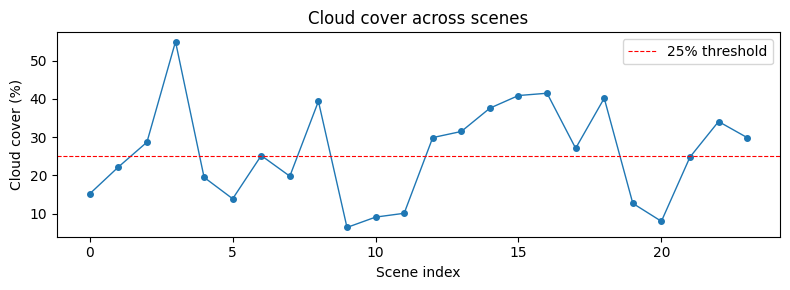

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, df['cloud_cover'], marker='o', markersize=4, linewidth=1)
ax.set_xlabel('Scene index')
ax.set_ylabel('Cloud cover (%)')
ax.set_title('Cloud cover across scenes')
ax.axhline(25, color='red', linestyle='--', linewidth=0.8, label='25% threshold')
ax.legend()
plt.tight_layout()
plt.show()

### 5.2) Histogram

A **histogram** divides values into equal-width intervals called **bins** and counts
how many values fall in each. `bins=10` means 10 intervals across the data range.
Fewer bins show the broad shape; more bins reveal detail (but can look noisy).

**Question:** What does the cloud cover distribution look like?

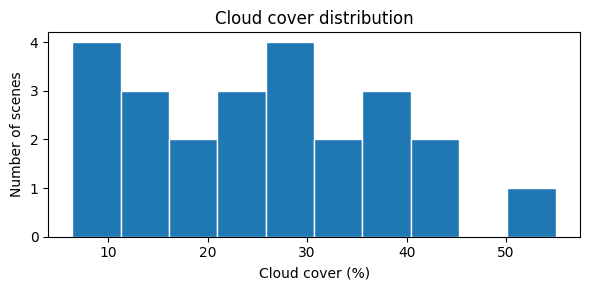

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df['cloud_cover'], bins=10, edgecolor='white')
ax.set_xlabel('Cloud cover (%)')
ax.set_ylabel('Number of scenes')
ax.set_title('Cloud cover distribution')
plt.tight_layout()
plt.show()

### 5.3) Scatter plot

**Question:** Is there a relationship between cloud cover and mean NDVI?

A scatter plot shows each observation as a point, letting you spot
correlations, clusters, or outliers at a glance.

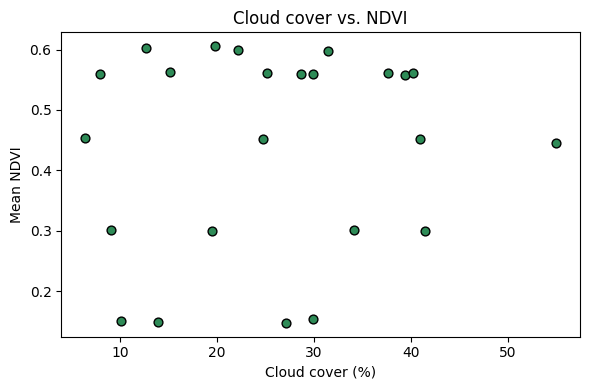

In [13]:
scene_mean_ndvi = ndvi.mean(axis=(1, 2))

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df['cloud_cover'], scene_mean_ndvi, c='seagreen', edgecolor='k', s=40)
ax.set_xlabel('Cloud cover (%)')
ax.set_ylabel('Mean NDVI')
ax.set_title('Cloud cover vs. NDVI')
plt.tight_layout()
plt.show()

### 5.4) Twin axes — two y-scales on one plot

When two variables have **different scales** (e.g. cloud cover in % and NDVI
around 0–1), you can use `ax.twinx()` to add a second y-axis.

```python
ax2 = ax.twinx()   # shares the same x-axis, new y-axis on the right
```

This is common in EO when comparing a quality metric against a biophysical variable.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Left y-axis — cloud cover as bars
ax.bar(df.index, df['cloud_cover'], color='steelblue', alpha=0.6, label='Cloud cover')
ax.set_xlabel('Scene index')
ax.set_ylabel('Cloud cover (%)', color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')

# Right y-axis — mean NDVI as a line
ax2 = ax.twinx()
ax2.plot(df.index, scene_mean_ndvi, color='green', marker='o', markersize=4, label='Mean NDVI')
ax2.set_ylabel('Mean NDVI', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax.set_title('Cloud cover vs. Mean NDVI per scene')
fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
plt.tight_layout()
plt.show()

### 5.5) imshow — displaying rasters

**Question:** What does the NDVI of the clearest scene look like?

In [ ]:
# Find the clearest scene
best_idx = df['cloud_cover'].idxmin()
best_scene_id = df.loc[best_idx, 'scene_id']
best_cloud = df.loc[best_idx, 'cloud_cover']
print(f'Clearest scene: {best_scene_id} (cloud={best_cloud}%)')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(ndvi[best_idx], cmap='YlGn', vmin=0, vmax=1)
axes[0].set_title(f'NDVI — {best_scene_id}')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

axes[1].imshow(cloud_mask[best_idx], cmap='gray_r')
axes[1].set_title('Cloud mask')

plt.tight_layout()
plt.show()

💡 **Tip — imshow & geographic data**

By default `imshow` puts row 0 at the **top**, which matches image convention (origin = upper-left).
For geographic data you might want south at the bottom — pass `origin='lower'`.

To add real-world coordinates to the axes, use the `extent=` parameter:

```python
ax.imshow(data, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower')
```

We will revisit this when working with xarray and rasterio in later notebooks.

### ✅ Try it — plot the cloudiest scene

Find the cloudiest scene (highest `cloud_cover`). Display its NDVI and cloud mask side-by-side using `imshow`.

<details>
<summary>Show solution</summary>

```python
worst_idx = df['cloud_cover'].idxmax()
worst_id = df.loc[worst_idx, 'scene_id']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im = axes[0].imshow(ndvi[worst_idx], cmap='YlGn', vmin=0, vmax=1)
axes[0].set_title(f'NDVI — {worst_id}')
plt.colorbar(im, ax=axes[0], shrink=0.8)

axes[1].imshow(cloud_mask[worst_idx], cmap='gray_r')
axes[1].set_title('Cloud mask')
plt.tight_layout()
plt.show()
```

</details>

In [ ]:
# ✅ Find cloudiest scene, plot NDVI + cloud mask side-by-side


### Bonus — pandas `.plot()`

pandas has a quick `.plot()` method built on matplotlib.  
Great for fast exploration; use raw matplotlib when you need full control.

In [ ]:
df.groupby('tile')['cloud_cover'].mean().plot.bar(
    ylabel='Mean cloud cover (%)',
    title='Mean cloud cover per tile',
    figsize=(6, 3),
)
plt.tight_layout()
plt.show()

---

## 6) 🧠 Mini capstone — build a processing shortlist

Combine everything you learned.  
Imagine you are building an NDVI time-series for a study area.

> ⚠️ This exercise uses `df_merged` from §2.9. If you skipped that section, run the merge cell first.

### Task

1. Define an AOI point: `lat = 49.79, lon = 9.95`.
2. Filter the catalog to scenes with `cloud_cover < 30`.
3. For each tile, keep only the **most recent** good scene.
4. Compute a simple distance from the AOI to each tile center.
5. Sort by distance and print the shortlist.
6. Export to CSV.
7. Plot the NDVI of the single best scene.

💡 *Hint: use `sort_values` + `drop_duplicates(subset='tile', keep='last')`.*

<details>
<summary>Show solution</summary>

```python
# --- Step 1: AOI ---
aoi_lat, aoi_lon = 49.79, 9.95

# --- Step 2: Filter ---
clear = df_merged[df_merged['cloud_cover'] < 30].copy()
print(f'{len(clear)} scenes with cloud < 30%')

# --- Step 3: Most recent per tile ---
clear = clear.sort_values('datetime')
latest = clear.drop_duplicates(subset='tile', keep='last')
print(f'{len(latest)} tiles after dedup')
latest[['scene_id', 'tile', 'datetime', 'cloud_cover']]

# --- Step 4: Distance from AOI ---
latest = latest.copy()
latest['dist_deg'] = np.sqrt(
    (latest['center_lat'] - aoi_lat)**2 +
    (latest['center_lon'] - aoi_lon)**2
)
latest = latest.sort_values('dist_deg')

# --- Step 5: Print shortlist ---
print('Processing shortlist (closest first):')
print(latest[['scene_id', 'tile', 'datetime', 'cloud_cover', 'dist_deg']].to_string(index=False))

# --- Step 6: Export ---
export_path = OUT_DIR / 'processing_shortlist.csv'
latest.to_csv(export_path, index=False)
print(f'Exported to {export_path}')

# --- Step 7: Plot best scene ---
best_row = latest.iloc[0]
best_global_idx = best_row.name  # original df index

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(ndvi[best_global_idx], cmap='YlGn', vmin=0, vmax=1)
ax.set_title(f"Best scene: {best_row['scene_id']}\ncloud={best_row['cloud_cover']}%")
plt.colorbar(im, ax=ax, shrink=0.8, label='NDVI')
plt.tight_layout()
plt.show()
```

</details>

In [ ]:
# 🧠 Build your processing shortlist (steps 1–7 above)
# Requires: df_merged from §2.9


---

## 7) Wrap-up

### What you learned

| Tool | Key skills |
|------|------------|
| **pandas** | `read_csv`, `[]`, `loc`/`iloc`, boolean filter, `sort_values`, `groupby`, `.apply()`, `merge`, method chaining, `to_csv` |
| **Datetime** | `pd.to_datetime`, `.dt.month`, `.isin()` |
| **NumPy** | shape, dtype, slicing, vectorised math, boolean masks, `np.nanmean`, spatial subsets, `np.stack`, `np.where` |
| **Matplotlib** | `plot` (line), `hist`, `scatter`, `twinx` (twin axes), `imshow`, subplots, colorbar |

### Common-mistake summary

| Mistake | Fix |
|---------|-----|
| `df['a', 'b']` | `df[['a', 'b']]` (double brackets) |
| `and` in pandas filter | use `&`, wrap in `()` |
| Modifying a view | use `.copy()` |
| Chained indexing | use `.loc[]` |
| `loc` vs `iloc` endpoint | `loc` includes stop, `iloc` excludes it |

### What's next

In the next notebooks you will use **xarray** to work with labelled, multi-dimensional data cubes,
**rasterio** to read real satellite GeoTIFFs, and **STAC** to search for data in the cloud.